In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# FENICSx imports
import ufl
import dolfinx
from mpi4py import MPI
from petsc4py.PETSc import ScalarType as dtype

sys.path.append('..')
%aimport mre_pinn

dtype

numpy.complex128

## 2D  Poisson forward FEM

We want to solve for $u: \Omega \to \mathbb{C}$ given the forcing field $f: \Omega \to \mathbb{C}$, where $\Omega \subset \mathbb{R}^2$.

Strong form:

$$
\begin{align}
    \nabla^2 u(\mathbf{x}) &= f(\mathbf{x}) &\quad &\mathbf{x} \in \Omega \\
    u(\mathbf{x}) &= u_D(\mathbf{x})        &\quad &\mathbf{x} \in \partial \Omega
\end{align}
$$

Variational form:

$$
\begin{align}
    \int_\Omega \nabla u \cdot \nabla \bar{v} d\Omega &= -\int_\Omega f \bar{v} d\Omega
\end{align}
$$

In [4]:
# define the mesh and function space

n_x = 16
n_y = 16

mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1, -1], [1, 1]], n=[n_x, n_y],
    cell_type=dolfinx.mesh.CellType.triangle
)

V = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))

In [5]:
# define the true displacement and source functions

def u_true(x):
    return x[0]**2 + x[1]**2

def f_true(x):
    return 4 * np.ones_like(x[0])

u_h = dolfinx.fem.Function(V)
u_h.interpolate(u_true)

f_h = dolfinx.fem.Function(V)
f_h.interpolate(f_true)

In [6]:
# create forward boundary condition

def on_boundary(x):
    return np.isclose(np.linalg.norm(x, np.inf, axis=0), 1)

boundary_dofs = dolfinx.fem.locate_dofs_geometrical(V, on_boundary)
u_bc = dolfinx.fem.dirichletbc(u_h, dofs=boundary_dofs)

In [7]:
%%time

# setup and solve variational Poisson problem

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = -ufl.inner(f_h, v) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[u_bc])
uhat_h = problem.solve()

CPU times: user 22.1 ms, sys: 88.4 ms, total: 111 ms
Wall time: 9.44 s


In [8]:
# evaluate function on mesh

x = np.stack(np.meshgrid(
    np.linspace(-1, 1, 101),
    np.linspace(-1, 1, 101),
    np.zeros(1),
), axis=-1).reshape(-1, 3)

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

uhat_x = uhat_h.eval(x, cells)
uhat_x = uhat_x.reshape(101, 101)
uhat_x.shape

(101, 101)

<IPython.core.display.Javascript object>


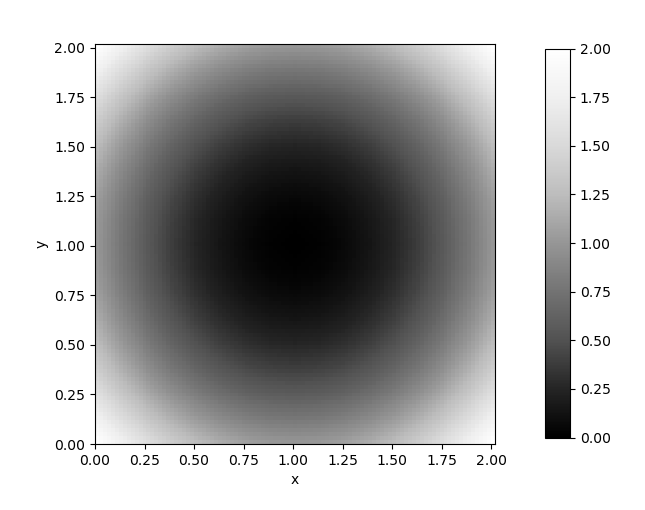

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [9]:
# visualize the displacement

import xarray as xr

dims = ['x', 'y']
coords = {
    'x': np.linspace(-1, 1, 101),
    'y': np.linspace(-1, 1, 101)
}
xr_uhat_x = xr.DataArray(uhat_x, dims=dims, coords=coords)

mre_pinn.visual.XArrayViewer(xr_uhat_x, ax_width=4, vmin=0, vmax=2, cmap='Greys_r')

# Poisson inverse FEM

Now we want to solve for $f: \Omega \to \mathbb{C}$ given the displacement field $u: \Omega \to \mathbb{C}$, where $\Omega \subset \mathbb{R}^2$.

Strong form:

$$
\begin{align}
    f(\mathbf{x}) &= \nabla^2 u(\mathbf{x}) \quad \mathbf{x} \in \Omega
\end{align}
$$

Variational form:

$$
\begin{align}
    \int_\Omega f \bar{g} d\Omega &= -\int_\Omega \nabla u \cdot \nabla \bar{g} d\Omega
\end{align}
$$

In [10]:
# create inverse boundary condition
f_bc = dolfinx.fem.dirichletbc(f_h, dofs=boundary_dofs)

In [12]:
%%time

# setup and solve variational Poisson problem

f = ufl.TrialFunction(V)
g = ufl.TestFunction(V)

a = ufl.inner(f, g) * ufl.dx
L = -ufl.inner(ufl.grad(u_h), ufl.grad(g)) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[f_bc])
fhat_h = problem.solve()

CPU times: user 4.8 ms, sys: 1.02 ms, total: 5.82 ms
Wall time: 13.6 ms


In [13]:
# evaluate function on mesh

x = np.stack(np.meshgrid(
    np.linspace(-1, 1, 101),
    np.linspace(-1, 1, 101),
    np.zeros(1),
), axis=-1).reshape(-1, 3)

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

fhat_x = fhat_h.eval(x, cells)
fhat_x = fhat_x.reshape(101, 101)
fhat_x.shape

(101, 101)

<IPython.core.display.Javascript object>


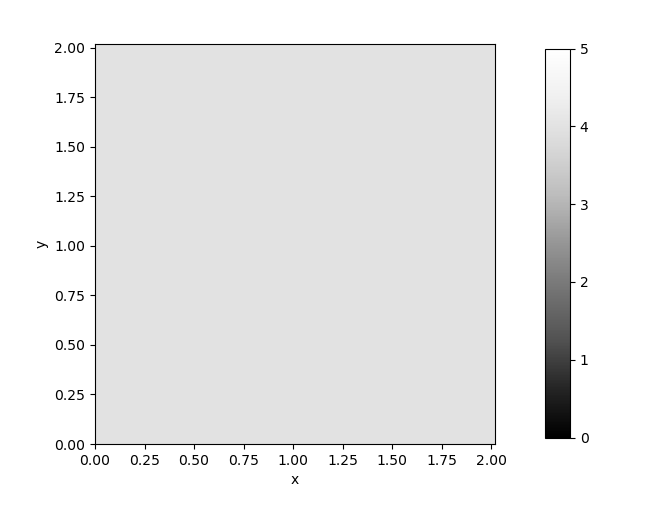

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [15]:
# visualize the displacement

import xarray as xr

dims = ['x', 'y']
coords = {
    'x': np.linspace(-1, 1, 101),
    'y': np.linspace(-1, 1, 101)
}
xr_fhat_x = xr.DataArray(fhat_x, dims=dims, coords=coords)

mre_pinn.visual.XArrayViewer(xr_fhat_x, ax_width=4, cmap='Greys_r', vmin=0, vmax=5)